# Music Generator

In [ ]:
# Import modules
import torch
import os
import torch.nn as nn
import librosa
from torchvision import transforms, utils
import numpy as np
#!pip install pydub
import pydub
from scipy.io.wavfile import read, write
import pandas as pd
from skimage import io, transform
import torch.nn.functional as F
#!pip install torchaudio
import torchaudio

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/'
rate, music1 = read(path + "stay.wav")
lower_bound, upper_bound = -32768, 32767

In [ ]:
# Define dataset
class MusicGenDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length, output_length=1):
        super(MusicGenDataset, self).__init__()
        self.data = data
        self.sequence_length = sequence_length
        self.output_length = output_length

    def __len__(self):
        # return the number of sequences in the dataset
        return (len(self.data) - 1) // self.sequence_length
        
    def __getitem__(self, idx):
        idx = idx * self.sequence_length
        d = self.data[idx:idx + self.sequence_length]
        if self.output_length == 1:
          label = self.data[idx + self.sequence_length]
        else:
          label = self.data[idx + 1: idx + 1 + self.sequence_length]
        # Normalize
        return d.reshape(1,-1).copy() / 32768, label.copy() / 32768

# Music Generator Network

In [ ]:
# LSTM based network that predicts the next sound amplitude given 50 previous sound amplitudes 
class MusicNet(nn.Module):
    def __init__(self, feature_size):
        super(MusicNet, self).__init__()
        self.feature_size = feature_size
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, num_layers=10, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(self.feature_size, 50)
        self.fc2 = nn.Linear(50, 1)
        
        

    def forward(self, x, hidden_state=None):
        x, hidden_state = self.lstm(x, hidden_state)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, hidden_state

    # Loss function
    def loss(self, prediction, label, reduction='elementwise_mean'):
        loss_val = F.mse_loss(prediction, label)
        return loss_val

In [ ]:
# Fully connected version of the model above with special weighted loss that takes into account style
class MusicNet2(nn.Module):
    def __init__(self, feature_size, output_size=1):
        super(MusicNet2, self).__init__()
        self.feature_size = feature_size
        self.hidden_size = feature_size
        self.fc1 = nn.Linear(self.hidden_size, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)
        self.genreNet = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/raw_fully_conn.pt', map_location=torch.device('cpu')).eval()
        
        

    def forward(self, x, hidden_state=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        features = x
        x = self.fc4(x)
        return x, hidden_state, features


    # Loss function
    def loss(self, prediction, label, style=None, features=None, reduction='mean'):
        weight = 1.0 if style is None else 0.7
        loss_val = weight * F.mse_loss(prediction, label)
        #loss_val = F.mse_loss(prediction.view(-1), label.view(-1))
        #loss_val = F.cross_entropy(output.view(-1, 32768 * 2), label.flatten())
        #loss_val = F.cross_entropy(prediction.view(-1, len(notes_encoding)), label.view(-1))
        if style is not None:
          with torch.no_grad():
            style_features = self.genreNet.get_feature(style)
          #prediction_features = self.genreNet.get_feature(prediction.reshape(-1,1,32,32))
          #loss_val += F.mse_loss(prediction_features, style_features.expand(280, -1,-1,-1))
          loss_val += (1 - weight) * F.mse_loss(features, style_features)
        return loss_val

In [ ]:
# LSTM based model that generates the next 50 sound amplitudes given 50 previous amplitudes.
# This was the final model we went with.
class MusicNet2(nn.Module):
    def __init__(self, feature_size, output_size=1):
        super(MusicNet2, self).__init__()
        self.feature_size = feature_size
        #self.encoder = nn.Embedding(len(notes_encoding), self.feature_size)
        #self.encoder = nn.Embedding(32768 * 2, self.feature_size)
        self.hidden_size = output_size
        self.lstm = nn.LSTM(input_size=self.feature_size, hidden_size=self.hidden_size, num_layers=5, batch_first=True, bidirectional=False)
        #self.decoder1 = nn.Linear(self.feature_size,(self.feature_size + len(notes_encoding)) // 2)
        #self.decoder2 = nn.Linear((self.feature_size + len(notes_encoding)) // 2, len(notes_encoding))
        #self.decoder = nn.Linear(self.feature_size, 1)#self.feature_size)
        #self.decoder = nn.Linear(self.feature_size, len(notes_encoding))
        #self.decoder = nn.Linear(self.hidden_size, 32768 * 2)
        #self.fc1 = nn.Linear(self.hidden_size, 250)
        #self.fc4 = nn.Linear(50, output_size)
        #self.fc4 = nn.Linear(50, 1)
        self.fc1 = nn.Linear(SEQUENCE_LENGTH, 200)
        self.fc2 = nn.Linear(200, SEQUENCE_LENGTH)
        self.feature_extractor = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/feature_predictor.pt', map_location=torch.device('cuda')).eval()
        self.genreNet = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/feature_fully_conn.pt', map_location=torch.device('cuda')).eval()
        
    def forward(self, x, hidden_state=None):
        
        x, hidden_state = self.lstm(x, hidden_state)
        x = x.squeeze()
        x = self.fc1(x)
        x = self.fc2(x)
        return x, hidden_state

    # Loss function
    def loss(self, prediction, label, style=None, features=None, reduction='mean'):
        weight = 1.0 if style is None else 0.5
        loss_val = weight * F.mse_loss(prediction, label)
        #loss_val = F.mse_loss(prediction.view(-1), label.view(-1))
        #loss_val = F.cross_entropy(output.view(-1, 32768 * 2), label.flatten())
        #loss_val = F.cross_entropy(prediction.view(-1, len(notes_encoding)), label.view(-1))
        if style is not None:
          with torch.no_grad():
            style_features = self.genreNet.get_feature(style)
          #prediction_features = self.genreNet.get_feature(prediction.reshape(-1,1,32,32))
          #loss_val += F.mse_loss(prediction_features, style_features.expand(280, -1,-1,-1))
          mfcc = self.feature_extractor(prediction * 32768)
          features = self.genreNet.get_feature(torch.cat((mfcc, torch.zeros((mfcc.shape[0],20)).to(device)), 1))
          loss_val += (1 - weight) * F.mse_loss(features, style_features)
        return loss_val

# Music Generator Training


In [ ]:
SEQUENCE_LENGTH = 50
FEATURE_SIZE = 1 #1024
EPOCHS = 10
BATCH_SIZE = 100 #280
model1 = MusicNet2(FEATURE_SIZE, FEATURE_SIZE)
#model2 = MusicNet2(FEATURE_SIZE, FEATURE_SIZE)
optim = torch.optim.Adam(model1.parameters(), lr=0.01)

data1 = MusicGenDataset(music1[:,0], SEQUENCE_LENGTH, SEQUENCE_LENGTH)
#data2 = MusicGenDataset(music1[:,1], SEQUENCE_LENGTH, SEQUENCE_LENGTH)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}

train1 = torch.utils.data.DataLoader(data1, batch_size=BATCH_SIZE,
                                            shuffle=True, **kwargs)
#train2 = torch.utils.data.DataLoader(data2, batch_size=BATCH_SIZE,
#                                            shuffle=True, **kwargs)
model1 = model1.to(device)
#model2 = model2.to(device)

# Load style audio
style, sr = torchaudio.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/santa.wav')
#shp = int(np.sqrt(len(style)))
#style = style[:shp * shp, 0]
#style = torch.tensor([[style.reshape((shp, shp))]]).float()
#style = F.interpolate(style, size=(32,32)).to(device)
style = style[0,:] # first channel

# Extract style features
mfcc = torchaudio.transforms.MFCC()(style)
mfcc = mfcc.squeeze().mean(dim=1).to(device)

for epoch in range(EPOCHS):
  for idx, (data, label) in enumerate(train1):
    data, label = data.detach().to(device), label.detach().to(device)
    data = data.float()
    label = label.float()
    #data = data.permute(2,0,1).long().squeeze() + 32768
    #label = label.permute(1,0).long() + 32768
    optim.zero_grad()

    data = data.reshape((data.shape[0], SEQUENCE_LENGTH, 1))
    output, hidden = model1(data) #torch.cat((data, style.view(1,1,-1).expand(BATCH_SIZE,-1,-1)), 2))
    
    loss = model1.loss(output, label, style=mfcc.expand(output.shape[0], -1))
    loss.backward()
    optim.step()
    if idx % 1000 == 0:
      print('Epoch:', epoch)
      print('Loss:', loss.item())
      print('Prediction:', output[0].squeeze())
      print('Truth:', label[0].squeeze())
      torch.save(model1, '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/' + 'lstm_generator_style.pt')
print('Finished training model 1')

Using device cuda
num workers: 2


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Epoch: 0
Loss: 1384.4371337890625
Prediction: tensor([ 0.0979,  0.0709, -0.0172,  0.1380,  0.0943,  0.0729,  0.1376,  0.0301,
        -0.1203,  0.0604, -0.0444,  0.0087, -0.0766,  0.0519, -0.1003, -0.0480,
        -0.0787, -0.0579,  0.0929, -0.1495,  0.0436, -0.0762,  0.0178, -0.0273,
        -0.0955, -0.0251, -0.1167, -0.0939,  0.0188, -0.1802,  0.0601, -0.1456,
        -0.1388,  0.0243,  0.1544,  0.0017,  0.0256,  0.0708,  0.1274, -0.0072,
        -0.0762, -0.1948, -0.0014,  0.2305, -0.0674, -0.0271, -0.0906, -0.0120,
        -0.2079, -0.0411], device='cuda:0', grad_fn=<SqueezeBackward0>)
Truth: tensor([-0.2684, -0.2747, -0.2785, -0.2842, -0.2911, -0.2935, -0.2924, -0.2939,
        -0.2967, -0.2957, -0.2944, -0.2983, -0.3048, -0.3100, -0.3163, -0.3256,
        -0.3354, -0.3455, -0.3581, -0.3733, -0.3904, -0.4108, -0.4335, -0.4558,
        -0.4771, -0.4982, -0.5172, -0.5338, -0.5502, -0.5670, -0.5827, -0.5987,
        -0.6172, -0.6358, -0.6505, -0.6623, -0.6733, -0.6830, -0.6906, -0.6

In [ ]:
# Music style transfer without any models. Modify the input audio directly. 
EPOCHS = 100
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)

#genre_classifier = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/sample_fully_conn.pt', map_location=device).eval()
input, rate = torchaudio.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/stay.wav')
input = input[0,:] # first channel only
input = input[:rate * 30]
input = input.to(device)
input.requires_grad = True
optim = torch.optim.Adam([input], lr=0.01)
original = input.detach().clone()

style, sr = torchaudio.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/santa.wav')
style = style[0,:] # first channel
style = style[:rate * 30]

# Get style audio features
style_mfcc = torchaudio.transforms.MFCC()(style).mean(dim=1).to(device)
#style_spec = torchaudio.transforms.Spectrogram()(style)#.mean(dim=1).to(device)
#style_mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(style)#.mean(dim=1).to(device)
style_features = style_mfcc
#style_features = torch.cat((style_mfcc, style_spec, style_mel_spec), dim=0)

# Original input audio features
ori = torchaudio.transforms.MFCC()(original)
ori = ori.squeeze().mean(dim=1).to(device)

for epoch in range(EPOCHS):
  optim.zero_grad()
  mfcc = torchaudio.transforms.MFCC()(input)
  mfcc = mfcc.squeeze().mean(dim=1).to(device)
  #spec = torchaudio.transforms.Spectrogram()(input).mean(dim=1).to(device)
  #mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=rate)(input)#.mean(dim=1).to(device)
  input_features = mfcc
  #input_features = torch.cat((mfcc, spec, mel_spec), dim=0)
  #output = genre_classifier(input_features)
  #print(folders[output.argmax()])
  #loss = F.cross_entropy(output.reshape((1,-1)), torch.tensor([8]).to(device))
  #loss = 10 * F.mse_loss(input, original) + 0.3 * F.mse_loss(input, style[:len(input)])
  loss = 30 * F.mse_loss(input_features, style_features) + 0.7 * F.mse_loss(input, original)
  loss.backward()
  optim.step()
  if epoch % 5 == 0:
    print('Epoch:', epoch)
    print('Loss:', loss.item())

input = input.detach().numpy() * 32768
write('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/output/' + 'october_diret_style.wav', rate, input.astype('int16'))
print('Finished training model 1')

Using device cpu


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Epoch: 0
Loss: 29488.494140625
Epoch: 5
Loss: 5491.09765625
Epoch: 10
Loss: 4405.59814453125
Epoch: 15
Loss: 3645.991943359375
Epoch: 20
Loss: 3012.6220703125
Epoch: 25
Loss: 2519.351318359375
Epoch: 30
Loss: 2183.3310546875
Epoch: 35
Loss: 1974.0423583984375
Epoch: 40
Loss: 1849.1259765625
Epoch: 45
Loss: 1773.8585205078125
Epoch: 50
Loss: 1726.780029296875
Epoch: 55
Loss: 1709.423095703125
Epoch: 60
Loss: 1693.6968994140625
Epoch: 65
Loss: 1694.10205078125
Epoch: 70
Loss: 1683.2303466796875
Epoch: 75
Loss: 1682.75927734375
Epoch: 80
Loss: 1678.3603515625
Epoch: 85
Loss: 1680.510009765625
Epoch: 90
Loss: 1692.53466796875
Epoch: 95
Loss: 1689.5057373046875
Finished training model 1


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'
torch.save(model1, path + 'lstm1_longer.pt')
torch.save(model2, path + 'lstm2_longer.pt')

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'
model1 = torch.load(path + 'lstm_generator_style.pt')
model2 = torch.load(path + 'lstm2_longer2nd.pt')

# Testing Music Generator

In [ ]:
BATCH_SIZE = 500
FEATURE_SIZE = 50 #8000#50
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

kwargs = {'num_workers': num_workers,
          'pin_memory': True} if use_cuda else {}
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/'
rate, music = read(path + "santa.wav")
data1 = MusicGenDataset(music[:,0], FEATURE_SIZE, FEATURE_SIZE)
#data2 = MusicGenDataset(music[:,1], FEATURE_SIZE)
loader1 = torch.utils.data.DataLoader(data1, batch_size=BATCH_SIZE,
                                            shuffle=False, **kwargs)
#loader2 = torch.utils.data.DataLoader(data2, batch_size=BATCH_SIZE,
                                            #shuffle=False, **kwargs)

pred1 = torch.tensor([]).float().to(device)
#pred1 = []
#pred2 = torch.tensor([]).float().to(device)
model1 = model1.to(device).eval()
#model2 = model2.to(device).eval()
with torch.no_grad():
  
  for idx, (data, label) in enumerate(loader1):
    data = data.float().to(device)
    #data = data.to(device)
    #print(data.shape)
    #data = data.permute(2,0,1)
    #data = data.squeeze()
    #output, _, _ = model1(data)
    data = data.reshape((BATCH_SIZE, FEATURE_SIZE, 1))
    output, _ = model1(data)
    #pred = output.squeeze()
    #pred = pred.permute(1,0)
    #pred = output.max(-1)[1]
    #pred = pred.cpu().detach().numpy().astype('int')
    #pred = [decode(pred[i]) for i in range(len(pred))]
    output = output * 32768
    #first_50 = output[0]
    #next = output[1:, -1]
    #pred1 = torch.cat((pred1, first_50, next), 0)
    pred1 = torch.cat((pred1, output.flatten()), 0)
    del data
    del output
    #torch.cuda.empty_cache()
    if idx == 250: #50:
      break
  print('Finished 1st channel')
  final = pred1.cpu().detach().numpy().astype('int16')#pred1.detach().numpy().astype('int16')
  print(final.shape)
  path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/output/'
  write(path + 'santa_gen_style.wav', rate, final)

Using device cuda
num workers: 2
Finished 1st channel
(6275000,)


# Audio Feature Predictor

In [ ]:
# Audio feature data loading
from scipy.io.wavfile import read, write
import pandas as pd
import random
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, folders, transform=None):
        super(MusicDataset, self).__init__()
        self.transform = transform
        # self.data_folder = data_folder
        self.folders = folders
        self.data = []
        #self.labels = []
        for folder in self.folders:
          print(folder)
          for file in os.listdir(os.path.join(data_folder, folder)):
            #self.data.append(os.path.join(data_folder, folder, file))
            path = os.path.join(data_folder, folder, file)
            sr, audio = read(path)
            #for i in range(len(audio) // 50):
            for _ in range(50):
              features = []
              i = random.randrange(0, len(audio) - 50, 1)
              y = audio[i:i + 50].astype('float')
            #rmse = librosa.feature.rmse(y=y)
            #chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            #spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            #zcr = librosa.feature.zero_crossing_rate(y)
              mfcc = librosa.feature.mfcc(y=y, sr=sr)
            #features = [np.mean(chroma_stft), np.mean(rmse), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]   
              for e in mfcc:
                features.append(np.mean(e))
              self.data.append((y, np.array(features)))
            

    def __len__(self):
         return len(self.data)
        
    def __getitem__(self, idx):
        y, features = self.data[idx]
        
        return y, features

In [ ]:
# Fully connected network that extracts features from raw audio amplitudes
import torch
import torch.nn as nn
import torch.nn.functional as F
class MusicFeatureNet(nn.Module):
    def __init__(self, output_size):
        super(MusicIdentifyNet, self).__init__()
        # input 50
        self.output_size = output_size
        self.fc1 = nn.Linear(50, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, self.output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    # Predefined loss function
    def loss(self, prediction, label):
        loss_val = F.mse_loss(prediction, label)
        return loss_val

In [ ]:
def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        data = data.float()
        label = label.float()
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            correct += torch.sum(torch.argmax(output, dim=1) == label)
            
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [ ]:
# Training, Testing
def main():
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 70
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'

    path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/genres/'

    #t = transforms.Compose([transforms.ToPILImage(mode='F'), transforms.Resize(32), transforms.ToTensor()])
    t = transforms.Compose([transforms.ToTensor()])
    #data_train = MusicDataset('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/spectrograms', folders, t)
    data_train = MusicDataset('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/genres', folders)
    #data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=True, **kwargs)
    #test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
    #                                          shuffle=False, **kwargs)

    model = MusicIdentifyNet(20).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    train_losses, test_losses, test_accuracies = [], [], []


    try:
        for epoch in range(EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            #test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            #test_losses.append((epoch, test_loss))
            #test_accuracies.append((epoch, test_accuracy))
            
            #torch.save(model, DATA_PATH + 'feature_predictor.pt')
            
            if epoch % 5 == 0:
              print('Epoch:', epoch)
              print('Training loss:', train_loss)
            

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        #torch.save(model, DATA_PATH + 'feature_predictor.pt')
        
        return model, device
final_model, device = main()

rock
reggae
pop
metal
jazz
hiphop
disco
country
classical
blues
Using device cpu
num workers: 2
Train Epoch: 0 [0/50000 (0%)]	Loss: 41299.093750
Train Epoch: 0 [2560/50000 (5%)]	Loss: 9253.749023
Train Epoch: 0 [5120/50000 (10%)]	Loss: 7560.312500
Train Epoch: 0 [7680/50000 (15%)]	Loss: 6261.485352
Train Epoch: 0 [10240/50000 (20%)]	Loss: 6711.502930
Train Epoch: 0 [12800/50000 (26%)]	Loss: 7549.749023
Train Epoch: 0 [15360/50000 (31%)]	Loss: 6858.142090
Train Epoch: 0 [17920/50000 (36%)]	Loss: 6195.878418
Train Epoch: 0 [20480/50000 (41%)]	Loss: 7341.308594
Train Epoch: 0 [23040/50000 (46%)]	Loss: 6697.265625
Train Epoch: 0 [25600/50000 (51%)]	Loss: 6525.827148
Train Epoch: 0 [28160/50000 (56%)]	Loss: 6060.447266
Train Epoch: 0 [30720/50000 (61%)]	Loss: 6337.792480
Train Epoch: 0 [33280/50000 (66%)]	Loss: 6419.886230
Train Epoch: 0 [35840/50000 (71%)]	Loss: 6265.835938
Train Epoch: 0 [38400/50000 (77%)]	Loss: 6769.198242
Train Epoch: 0 [40960/50000 (82%)]	Loss: 6435.232910
Train Epoch

# Genre Classification

In [ ]:
import torch
import os
import torch.nn as nn
import librosa
from torchvision import transforms, utils
import numpy as np

In [ ]:
# Read how many genres exist in our data set
import os
IN_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/genres'
OUT_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/spectrograms'
for folder in os.walk(IN_PATH):
  folders = folder[1]
  break
print(folders)

['rock', 'reggae', 'pop', 'metal', 'jazz', 'hiphop', 'disco', 'country', 'classical', 'blues']


In [ ]:
# Generate Spectrograms
import matplotlib.pyplot as plt
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
for folder in folders:
  os.makedirs(os.path.join(OUT_PATH, folder), exist_ok=True)
  print(folder)
  for file in os.listdir(os.path.join(IN_PATH, folder)):
    y, sr = librosa.load(os.path.join(IN_PATH, folder, file), mono=True, duration=5)
    rmse = librosa.feature.rmse(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    features = [torch.mean(chroma_stft), torch.mean(rmse), torch.mean(spec_cent), torch.mean(spec_bw), torch.mean(rolloff), torch.mean(zcr)]   
    for e in mfcc:
        features.append(torch.mean(e))
    break
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
    plt.axis('off');
    #plt.show()
    plt.savefig(os.path.join(OUT_PATH, folder,f'{file[:-3].replace(".", "")}.png'))
    plt.clf()

NameError: ignored

<Figure size 576x576 with 0 Axes>

In [ ]:
# Spectrogram Data Loading
from skimage import io, transform
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, folders, transform=None):
        super(MusicDataset, self).__init__()
        self.transform = transform
        # self.data_folder = data_folder
        self.folders = folders
        self.data = []
        self.training = True
        for folder in os.listdir(data_folder):
          for file in os.listdir(os.path.join(data_folder, folder)):
            path = os.path.join(data_folder, folder, file)
            self.data.append(path)

    def set_training(is_training):
        self.training = is_training

    def __len__(self):
        # return the number of songs
         return len(self.data)
        
    def __getitem__(self, idx):
        data = self.data[idx]
        img = io.imread(data)[:,:,:3]
        if self.transform:
          img = self.transform(img)
        label = self.folders.index(os.path.basename(os.path.dirname(data)))
        return img, label

In [ ]:
# Raw Data Loading
from scipy.io.wavfile import read, write
import pandas as pd
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, folders, transform=None):
        super(MusicDataset, self).__init__()
        self.transform = transform
        # self.data_folder = data_folder
        self.folders = folders
        self.data = []
        for folder in self.folders:
          for file in os.listdir(os.path.join(data_folder, folder)):
            path = os.path.join(data_folder, folder, file)
            self.data.append(path)

    def __len__(self):
        # return the number of songs
         return len(self.data)
        
    def __getitem__(self, idx):
        
        data = self.data[idx]
        rate, audio = read(data)
        label = self.folders.index(os.path.basename(os.path.dirname(data)))
        return audio, label

In [ ]:
# Raw Data resample Loading
from scipy.io.wavfile import read, write
import pandas as pd
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, folders, transform=None):
        super(MusicDataset, self).__init__()
        self.transform = transform
        # self.data_folder = data_folder
        self.folders = folders
        self.data = []
        for folder in self.folders:
          for file in os.listdir(os.path.join(data_folder, folder)):
            path = os.path.join(data_folder, folder, file)
            self.data.append(path)

    def __len__(self):
        # return the number of songs
         return len(self.data)
        
    def __getitem__(self, idx):
        num_output = 882000#8000
        
        data = self.data[idx]
        rate, audio = read(data)
        total_samples = len(audio)
        seconds = total_samples // rate
        samples_per_sec = num_output // seconds
        extras =  num_output - samples_per_sec * seconds
        left_over = audio[seconds * samples_per_sec:]
        audio = audio[: seconds * samples_per_sec]
        audio = audio.reshape((seconds, -1))
        #audio = np.array_split(audio, seconds)
        #audio = np.array(audio)
        sampled = []
        for i in range(len(audio)):
          second = audio[i]
          sampled = sampled + np.random.choice(second, samples_per_sec, replace=False).tolist()
        sampled = sampled + np.random.choice(left_over, extras, replace=False).tolist()
        # Need to sample 8000 amplitudes from audio
        # Each second contains "rate" samples. Want to sample from
        # all seconds uniformly. 
        final = np.array(sampled)
        if self.transform:
          final = self.transform(final)
        label = self.folders.index(os.path.basename(os.path.dirname(data)))
        return final, label

In [ ]:
# Feature Data Loading
!pip install torchaudio
from scipy.io.wavfile import read, write
import torchaudio
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, folders, device, transform=None):
        super(MusicDataset, self).__init__()
        self.transform = transform
        # self.data_folder = data_folder
        self.folders = folders
        self.data = []
        self.device = device
        for folder in self.folders:
          for file in os.listdir(os.path.join(data_folder, folder)):
            path = os.path.join(data_folder, folder, file)
            self.data.append(path)

    def __len__(self):
        # return the number of songs
         return len(self.data)
        
    def __getitem__(self, idx):
        
        data = self.data[idx]
        #audio, sr = torchaudio.load(data)
        #audio = audio[:,sr * 4: sr * 4 + 50]
        #mfcc = torchaudio.transforms.MFCC()(audio, padding=0)
        #mfcc = mfcc.squeeze().mean(dim=1)
        input, rate = torchaudio.load(data)
        input = input.squeeze()
        mfcc = torchaudio.transforms.MFCC()(input)
        mfcc = mfcc.squeeze().mean(dim=1).to(self.device)
        spec = torchaudio.transforms.Spectrogram()(input).mean(dim=1).to(self.device)
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=rate)(input).mean(dim=1).to(self.device)
        input_features = torch.cat((mfcc, spec, mel_spec), dim=0)
        
        label = self.folders.index(os.path.basename(os.path.dirname(data)))
        return input_features, label

# Genre Classification Network

In [ ]:
# CNN that classifies genre from a spectrogram
import torch
import torch.nn as nn
import torch.nn.functional as F
class MusicIdentifyNet(nn.Module):
    def __init__(self, output_size):
        super(MusicIdentifyNet, self).__init__()
        # input 576 x 576 x 3
        # spectrogram resized 128 x 128 x 3
        # raw resized 32 x 32 x 1
        self.output_size = output_size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.fc = nn.Linear(32768, self.output_size)
        self.fc = nn.Linear(2048, self.output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc(x)
        return x

    def get_feature(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        return x

    # Predefined loss function
    def loss(self, prediction, label):
        loss_val = F.cross_entropy(prediction, label)
        return loss_val

In [ ]:
# Genre classification using a fully connected network. Inputs are audio features.
import torch
import torch.nn as nn
import torch.nn.functional as F
class MusicIdentifyNet(nn.Module):
    def __init__(self, output_size):
        super(MusicIdentifyNet, self).__init__()
        # input 8000
        # Features 40
        # 882000 audio samples
        self.output_size = output_size
        #self.fc = nn.Linear(661794, 10)
        self.fc1 = nn.Linear(369, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 100)
        self.fc4 = nn.Linear(100, self.output_size)
        

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        #x = self.fc(x)
        return x

    def get_feature(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

    # Predefined loss function
    def loss(self, prediction, label):
        loss_val = F.cross_entropy(prediction, label)
        return loss_val

In [ ]:
def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        #data = data.float()
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            correct += torch.sum(torch.argmax(output, dim=1) == label)
            
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [ ]:
# Training, Testing
def main():
    BATCH_SIZE = 50#128#256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 30
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'

    path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/genres/'

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    data_train = MusicDataset('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/genres', folders, device)
    
    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=True)#, **kwargs)
    
    model = MusicIdentifyNet(10).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    train_losses, test_losses, test_accuracies = [], [], []
    try:
        for epoch in range(EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            #test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            #test_losses.append((epoch, test_loss))
            #test_accuracies.append((epoch, test_accuracy))
            
            torch.save(model, DATA_PATH + 'large_fully_conn.pt')
            if epoch % 5 == 0:
              print('Epoch:', epoch)
              print('Training loss:', train_loss)
            

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        torch.save(model, DATA_PATH + 'large_fully_conn.pt')
        return model, device
final_model, device = main()

Using device cuda
num workers: 2
torch.Size([369])


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Train Epoch: 0 [0/1000 (0%)]	Loss: 2.523378
Train Epoch: 0 [500/1000 (50%)]	Loss: 1.876901
Epoch: 0
Training loss: 2.0402449786663057
Train Epoch: 1 [0/1000 (0%)]	Loss: 1.476927
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.351130
Train Epoch: 2 [0/1000 (0%)]	Loss: 1.280463
Train Epoch: 2 [500/1000 (50%)]	Loss: 1.417045
Train Epoch: 3 [0/1000 (0%)]	Loss: 1.040135
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.038127
Train Epoch: 4 [0/1000 (0%)]	Loss: 1.063559
Train Epoch: 4 [500/1000 (50%)]	Loss: 1.167477
Train Epoch: 5 [0/1000 (0%)]	Loss: 1.022339
Train Epoch: 5 [500/1000 (50%)]	Loss: 1.341738
Epoch: 5
Training loss: 0.9724592953920365
Train Epoch: 6 [0/1000 (0%)]	Loss: 0.654276
Train Epoch: 6 [500/1000 (50%)]	Loss: 0.734699
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.970754
Train Epoch: 7 [500/1000 (50%)]	Loss: 0.843862
Train Epoch: 8 [0/1000 (0%)]	Loss: 0.676677
Train Epoch: 8 [500/1000 (50%)]	Loss: 0.850532
Train Epoch: 9 [0/1000 (0%)]	Loss: 0.804677
Train Epoch: 9 [500/1000 (50%)]	Loss: 0.810039
Trai

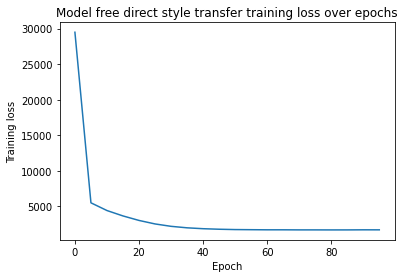

In [ ]:
import matplotlib.pyplot as plt
text = ''
train_loss = []
for line in text.splitlines():
  if 'Loss' in line or 'loss' in line:
    train_loss.append(float(line.split()[-1]))
plt.plot(range(0,96,5), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Model free direct style transfer training loss over epochs')
plt.show()

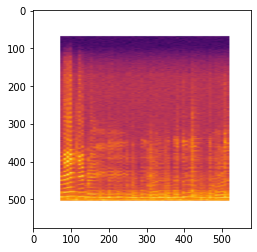

In [ ]:
t = transforms.Compose([transforms.ToPILImage(), transforms.Resize(128), transforms.ToTensor()])
data_train = MusicDataset('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/spectrograms', folders, t)
imgplot = plt.imshow(torch.transpose(torch.transpose(data_train[0][0], 0,2), 0, 1))

# Interpolater



In [ ]:
# Raw Data Loading
from scipy.io.wavfile import read, write
import pandas as pd
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, data, rate):
        super(MusicDataset, self).__init__()
        self.data = data
        self.rate = rate
        self.repeats = 50

    def __len__(self):
        # return the number of songs
         return self.repeats *(len(self.data) // self.rate)
        
    def __getitem__(self, idx):
        idx = self.rate * (idx // self.repeats)
        data = np.random.choice(self.data[idx:idx + rate], size=500, replace=False)
        label = self.data[idx:idx + rate]
        return data.copy() / 32768, label.copy() / 32768

In [ ]:
# Raw audio fully connected network
import torch
import torch.nn as nn
import torch.nn.functional as F
class MusicInterpolateNet(nn.Module):
    def __init__(self, output_size):
        super(MusicInterpolateNet, self).__init__()
        # input 500
        self.fc1 = nn.Linear(500, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # Predefined loss function
    def loss(self, prediction, label):
        loss_val = F.mse_loss(prediction, label)
        return loss_val

In [ ]:
def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        data = data.float()
        label = label.float()
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            correct += torch.sum(torch.argmax(output, dim=1) == label)
            
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [ ]:
# Training, Testing
def main():
    BATCH_SIZE = 50#128#256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'

    path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/'

    t = transforms.Compose([transforms.ToTensor()])
    rate, audio = read(path + 'stay.wav')
    audio = audio[:,0]
    data_train = MusicDataset(audio, rate)
    print(data_train[0][0].shape)
    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=True, **kwargs)
    #test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
    #                                          shuffle=False, **kwargs)

    model = MusicInterpolateNet(rate).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = [], [], []
    try:
        for epoch in range(EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            #test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            #test_losses.append((epoch, test_loss))
            #test_accuracies.append((epoch, test_accuracy))
            torch.save(model, DATA_PATH + 'interpolate.pt')
            if epoch % 5 == 0:
              print('Epoch:', epoch)
              print('Training loss:', train_loss)
            

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        torch.save(model, DATA_PATH + 'interpolate.pt')
        return model, device
final_model, device = main()

In [ ]:
# Interpolate between audio using the interpolation network
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/'
rate, audio = read(path + 'stay.wav')
audio = audio[:,0]
model = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/interpolate.pt').to(device)
pred = torch.tensor([]).to(device)
for i in range(len(audio) // rate):
  data = torch.from_numpy(np.random.choice(audio[i * rate:i * rate + rate], size=500, replace=False))
  data = data.unsqueeze(0).to(device).float()
  output = model(data)
  pred = torch.cat((pred, output.flatten()), dim=0)

pred = pred.cpu().detach().numpy() * 32768
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/output/'
write(path + 'stay_interpolate.wav', rate, pred.astype('int16'))


# Extra stuff: Random MIDI generator


In [ ]:
from music21 import converter, instrument, note, chord
import glob
notes = []
for file in glob.glob('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/*.mid'):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [ ]:
!pip install mido
import mido
mid = mido.MidiFile('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/Pirates.mid', clip=True)
mid.tracks

[<midi track "He's A Pirate" 9 messages>,
 <midi track 'Right Hand' 1285 messages>,
 <midi track 'Left Hand' 1557 messages>]

In [ ]:
import string
import numpy as np
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [ ]:
import torch
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self, audio):
        super(MusicDataset, self).__init__()
        self.audio = audio

    def __len__(self):
        # return the number of songs
         return len(self.audio) - 5
        
    def __getitem__(self, idx):
        data = self.audio[idx:idx + 5]
        return data.copy(), self.audio[idx + 1].copy()

In [ ]:
# Raw audio fully connected network
import torch
import torch.nn as nn
import torch.nn.functional as F
class MidiNet(nn.Module):
    def __init__(self, output_size):
        super(MidiNet, self).__init__()
        # input 500
        self.lstm = nn.LSTM(input_size=88, hidden_size=88, batch_first=True)
        self.fc = nn.Linear(88 * 5, 88)

    def forward(self, x):
        x, hidden = self.lstm(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

    # Predefined loss function
    def loss(self, prediction, label):
        loss_val = F.mse_loss(prediction, label)
        return loss_val

In [ ]:
def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        data = data.float()
        label = label.float()
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += model.loss(output, label).item()
            correct += torch.sum(torch.argmax(output, dim=1) == label)
            
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

In [ ]:
# Training, Testing
def main():
    BATCH_SIZE = 50#128#256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 10
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = False
    PRINT_INTERVAL = 10
    DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/'

    path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/data/midi/'

    audio = mid2arry(mid)
    data_train = MusicDataset(audio)
    print(data_train[0][0].shape)
    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=True, **kwargs)
    #test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
    #                                          shuffle=False, **kwargs)

    model = MidiNet(88).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    train_losses, test_losses, test_accuracies = [], [], []

    try:
        for epoch in range(EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            #test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            #test_losses.append((epoch, test_loss))
            #test_accuracies.append((epoch, test_accuracy))
            torch.save(model, DATA_PATH + 'midi.pt')
            if epoch % 5 == 0:
              print('Epoch:', epoch)
              print('Training loss:', train_loss)
            

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        torch.save(model, DATA_PATH + 'midi.pt')
        return model, device
final_model, device = main()

(5, 88)
Using device cpu
num workers: 2
Train Epoch: 0 [0/49674 (0%)]	Loss: 456.572601
Train Epoch: 0 [500/49674 (1%)]	Loss: 481.123871
Train Epoch: 0 [1000/49674 (2%)]	Loss: 390.540955
Train Epoch: 0 [1500/49674 (3%)]	Loss: 395.439514
Train Epoch: 0 [2000/49674 (4%)]	Loss: 330.397491
Train Epoch: 0 [2500/49674 (5%)]	Loss: 301.162598
Train Epoch: 0 [3000/49674 (6%)]	Loss: 291.853790
Train Epoch: 0 [3500/49674 (7%)]	Loss: 252.044922
Train Epoch: 0 [4000/49674 (8%)]	Loss: 249.183411
Train Epoch: 0 [4500/49674 (9%)]	Loss: 173.539581
Train Epoch: 0 [5000/49674 (10%)]	Loss: 187.119537
Train Epoch: 0 [5500/49674 (11%)]	Loss: 195.175888
Train Epoch: 0 [6000/49674 (12%)]	Loss: 159.003311
Train Epoch: 0 [6500/49674 (13%)]	Loss: 167.463821
Train Epoch: 0 [7000/49674 (14%)]	Loss: 147.693054
Train Epoch: 0 [7500/49674 (15%)]	Loss: 147.250763
Train Epoch: 0 [8000/49674 (16%)]	Loss: 121.766296
Train Epoch: 0 [8500/49674 (17%)]	Loss: 133.418243
Train Epoch: 0 [9000/49674 (18%)]	Loss: 113.596138
Train

In [ ]:
USE_CUDA = False
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
final_model = torch.load('/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/models/midi.pt')
start_note = audio[0:5]
length = len(audio)
input = torch.from_numpy(start_note).unsqueeze(0).to(device).float()
pred = input.clone().squeeze()
with torch.no_grad():
  for i in range(length):
    output = final_model(input)
    pred = torch.cat((pred, output), dim=0)
    input = pred[-5:].unsqueeze(0)
    if i % 1000 == 0:
      print(i)

mid_new = arry2mid(pred.cpu().detach().numpy().astype('int64'), 545455)
path = '/content/drive/MyDrive/Colab Notebooks/Music_Style_Transfer/output/'
mid_new.save(path + 'mid_new.mid')

Using device cpu
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
